# The Portfolio optimization problem 

Modern [Portfolio optimization](https://en.wikipedia.org/wiki/Portfolio_optimization) is a problem that involves finding the best set of assets that maximize the profit of those assets minimizing the risk of the investment. Usually, the risks are associated with changes in the market that makes the set of assets lose its value, and therefore investors lose part of their budget. 

This problem is known to be an NP-hard problem and its objective function is given by 

<div class="alert alert-block alert-success">
$$\max_{x} : \mu^{T} x-q x^{T} \Sigma x$$
</div>

Subject to: 
    $$\sum_{i=1}^{N} c_i x_i = B$$

where:
- $N$ represents the number of assets
- $x \in\{0,1\}^{N}$ denotes the vector of binary decision variables, which indicate which assets to pick ( $\left.x[i]=1\right)$ and which not to pick $(x[i]=0)$,
- $\mu \in R^{n}$ defines the expected returns for the assets,
- $\Sigma \in R^{n \times n}$ specifies the covariances between the assets,
- $q>0$ controls the risk aversion of the decision maker,
- $c_i$ is the cost of investing in the ith asset
- $B$ denotes the budget, i.e., the total investment..


In [1]:
%matplotlib notebook

# Import external libraries to present an manipulate the data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import docplex model to generate the problem to optimize
from docplex.mp.model import Model

# Import the libraries needed to employ the QAOA quantum algorithm using OpenQAOA
from openqaoa import QAOA

# method to covnert a docplex model to a qubo problem
from openqaoa.problems.converters import FromDocplex2IsingModel
from openqaoa.backends import create_device

# method to find the corrects states for the QAOA boject 
from openqaoa.utilities import ground_state_hamiltonian

## Generate the data

To simplify the problem, it is used a random function to generate the predictions the expected return for 10 assets during 15 days. Additionally, the cost of investment in each assets (c<sub>i</sub>) is set to 1.

In [2]:
# For the case of reproducibility this seed is configured
np.random.seed(1)

# Init variables to geretate the data
# consider the number of the assets and the numbero f days 
num_assets = 10
num_days = 15

# Risk aversion
q = 0.01 

# The limit of the budget, is consider as constraint
Budget = 5

# Cost of buying the different assets c_i
c = num_assets * [1] 
# Creating a random history of the forcasting for the expected return 
hist_exp = (1 - 2 * np.random.rand(num_assets)).reshape(-1,1) * (np.array([np.arange(num_days) for i in range(num_assets)]) + np.random.randint(10)) + (1 - 2 * np.random.rand(num_assets,  num_days)) 

# Mean expected return over the  num_days value
mu = hist_exp.mean(axis=1)
# Covariance matrix (Sigma) for the risk term of the cost function
sigma = np.cov(hist_exp) 

Graphical representation of 10 stock behavior and covariance matrix.

<IPython.core.display.Javascript object>


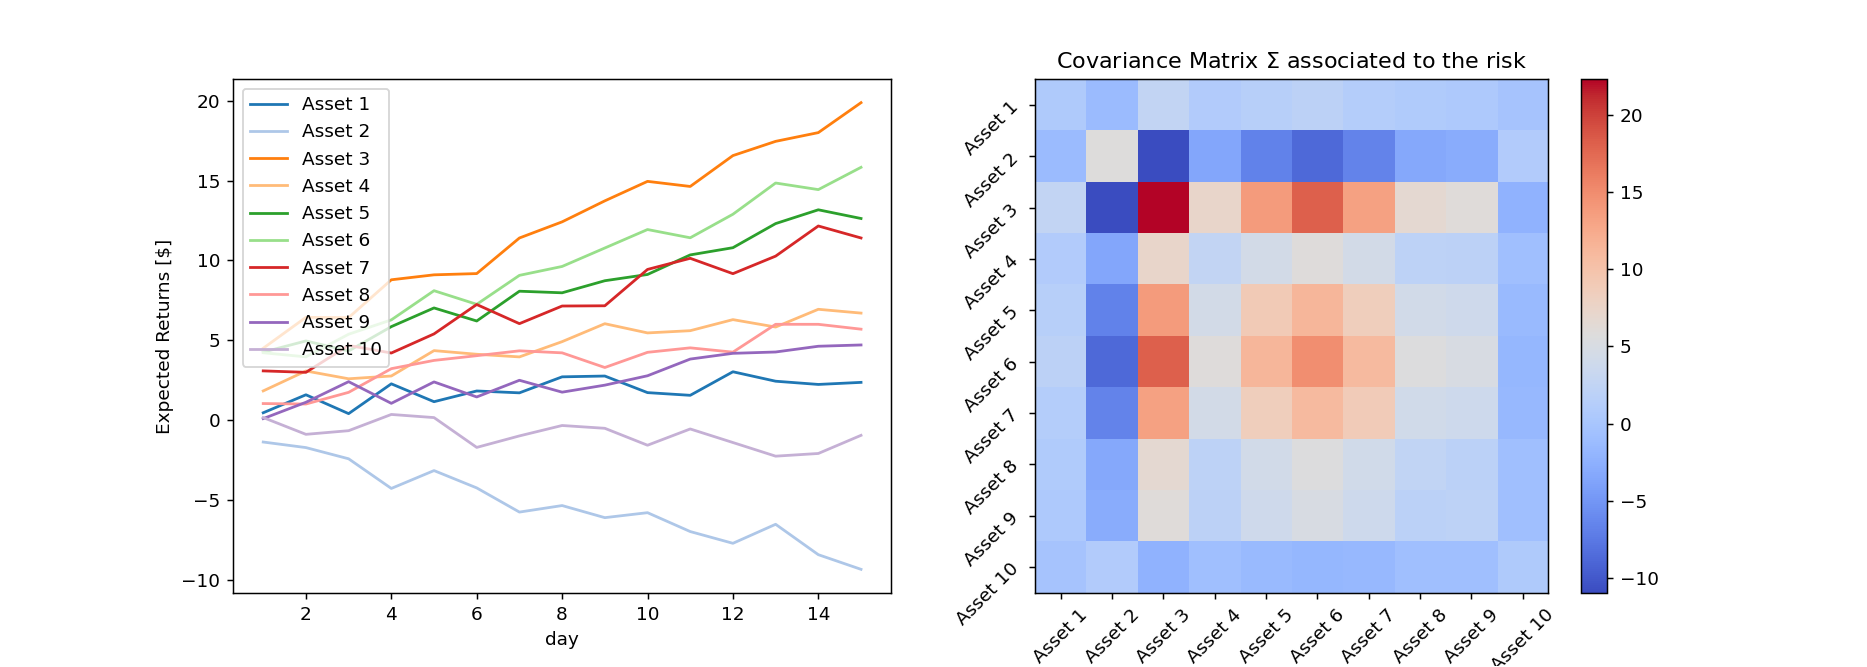

Text(0.5, 1.0, 'Covariance Matrix $\\Sigma$ associated to the risk')

In [3]:
# Plot the stock's time series
fig, ax = plt.subplots(1, 2, figsize=(14,5))
colors = plt.cm.tab20(range(20))
for i in range(num_assets):
    ax[0].plot(range(1, num_days+1), hist_exp[i], color=colors[i])
ax[0].set_xlabel("day")
ax[0].set_ylabel("Expected Returns [$]")
ax[0].legend([f"Asset {i}" for i in range(1, num_assets+1)])
im = ax[1].imshow(sigma, cmap="coolwarm")
fig.colorbar(im)

# Plot the covariance matrix
ax[1].set_yticks(range(num_assets))
ax[1].set_xticks(range(num_assets))
ax[1].set_xticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_yticklabels([f"Asset {i}" for i in range(1, num_assets+1)], rotation=45)
ax[1].set_title(r"Covariance Matrix $\Sigma$ associated to the risk")

## Obtain the Quadratic problem from DOCPLEX

Once it is obtained the data for the portfolio optmization problem, the next step is to translate it into a docplex model. Considering the above data of expected returns, covariances, risk factor, and budget the docplex model to solve it is given by

In [4]:
#Start the docplex model with Model("name of the model")
mdl = Model('Portfolio Optimization')

# Consider the number of variables as num_assets,
# and binary set of variables that represent the stocks
# x vector in numpy array for matrix multiplication
x = np.array(mdl.binary_var_list(num_assets, name="asset")) 

#Specific the objective of the 
# portfolio optimization function
objective_function = mu @ x - x.T @ sigma @ x

# For this problem it aims to maximize the profit 
# of those assets minimizing the risk of the investment
mdl.maximize(objective_function)

# Budget constraint
mdl.add_constraint(c @ x == Budget, ctname='budget')

# Printing the docplex model
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: Portfolio Optimization
// var contrainer section
dvar bool asset[10];

maximize
 1.881355 asset_0 - 5.283574 asset_1 + 12.236010 asset_2 + 4.699490 asset_3
 + 8.388273 asset_4 + 9.738609 asset_5 + 7.370289 asset_6 + 3.824391 asset_7
 + 2.622312 asset_8 - 0.885102 asset_9 [ - 0.612974 asset_0^2
 + 2.666327 asset_0*asset_1 - 5.200267 asset_0*asset_2
 - 1.784143 asset_0*asset_3 - 2.990688 asset_0*asset_4
 - 3.865797 asset_0*asset_5 - 2.501242 asset_0*asset_6
 - 1.504942 asset_0*asset_7 - 0.984580 asset_0*asset_8
 + 0.437093 asset_0*asset_9 - 5.766480 asset_1^2 + 21.930022 asset_1*asset_2
 + 7.073813 asset_1*asset_3 + 13.507653 asset_1*asset_4
 + 17.473295 asset_1*asset_5 + 13.144398 asset_1*asset_6
 + 6.706427 asset_1*asset_7 + 5.917903 asset_1*asset_8
 - 1.979177 asset_1*asset_9 - 22.322708 asset_2^2 - 14.491830 asset_2*asset_3
 - 27.657138 asset_2*asset_4 - 36.081466 asset_2*asset_5
 - 26.615248 asset_2*asset_6 - 13.368734 ass

##  Solving the problem using OpenQAOA


The class `FromDocplex2IsingModel` from OpenQAOA converts the docplex representation of the problem to its QUBO representation in Ising encoding (-1, 1). From there, it is only required setting the QAOA model and solve the QUBO.

In [5]:
# Converting the Docplex model of portfolio into its qubo representation
qubo_po = FromDocplex2IsingModel(mdl)

# Ising encoding of the QUBO problem for portfolio optimization
ising_encoding_po = qubo_po.ising_model 

# Docplex of the QUBO probolem for portfolio optimization
mdl_qubo_docplex = qubo_po.qubo_docplex

The quantum algorithm consider the following properties: the qiskit's qasm_simulator backend and 128 shots with a p value equals to 2, with  betas and gammas  of $0.01 * \pi$ 

In [6]:
# Indicate the device, this case is a local simulator
device = create_device("local", 'qiskit.qasm_simulator')

# Initilize the QAOA object
qaoa_po = QAOA(device)

# Set the parameters to work the QAOA algorithm
qaoa_po.set_backend_properties(n_shots=128, seed_simulator=1)
qaoa_po.set_circuit_properties(p=2, init_type="custom", variational_params_dict={"betas":2*[0.1*np.pi],"gammas":2*[0.1*np.pi]})
qaoa_po.compile(ising_encoding_po)

# Run the QAOA algorithm
qaoa_po.optimize()

show the best 5 states for this particular Portfolio optimization problem

In [7]:
# Print the best 5 solutions
qaoa_po_dict = qaoa_po.result.lowest_cost_bitstrings(5)
pd.DataFrame(qaoa_po_dict)

,solutions_bitstrings,bitstrings_energies,probabilities
0,1101100001,-2.604273,0.007812
1,1101000101,-2.472965,0.015625
2,1101000110,-0.468119,0.015625
3,1100010101,1.112393,0.007812
4,1100101001,1.718958,0.007812


Chek the correct answer using the ground_state_hamiltonian.

In [8]:
# Check the exactly solution
sol = ground_state_hamiltonian(qaoa_po.cost_hamil)
sol

(-2.6042725099164272, ['1101100001'])

## Solution using DOCPLEX

The QUBO problem can be solved classically using DOCPLEX. This is a good comparision between QAOA against classical optimizers.

**Note: For the next cell you  will need to install cplex with the command** `pip install cplex>=22.1.0.0` 

In [9]:
# Docplex QUBO model
mdl_qubo_po = qubo_po.qubo_docplex 

# Obtain the docplex solution
sol_po_docplex = mdl_qubo_po.solve()
sol_po = {i.name: int(sol_po_docplex.get_value(i)) for i in mdl_qubo_po.iter_binary_vars()}
sol_po

{'asset_0': 1,
 'asset_1': 1,
 'asset_2': 0,
 'asset_3': 1,
 'asset_4': 1,
 'asset_5': 0,
 'asset_6': 0,
 'asset_7': 0,
 'asset_8': 0,
 'asset_9': 1}

The solution is `1101100001`, the same state as in the quantum algorithm